# Goal: 45 Walmart stores with given department

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.impute import SimpleImputer

# Configuration
pd.set_option('display.max_columns', None)

In [202]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sampleSubmission.csv')
store_df = pd.read_csv('stores.csv')
feature_df = pd.read_csv('features.csv')

In [3]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
store_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
feature_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
train_df.Date, test_df.Date

(0         2010-02-05
 1         2010-02-12
 2         2010-02-19
 3         2010-02-26
 4         2010-03-05
              ...    
 421565    2012-09-28
 421566    2012-10-05
 421567    2012-10-12
 421568    2012-10-19
 421569    2012-10-26
 Name: Date, Length: 421570, dtype: object,
 0         2012-11-02
 1         2012-11-09
 2         2012-11-16
 3         2012-11-23
 4         2012-11-30
              ...    
 115059    2013-06-28
 115060    2013-07-05
 115061    2013-07-12
 115062    2013-07-19
 115063    2013-07-26
 Name: Date, Length: 115064, dtype: object)

# Wiggle Room

In [ ]:
test_dates = test_df['Date'].unique()
all_stores = test_df['Store'].unique()
train_dates = train_df['Date'].unique()
test_depts = test_df['Dept'].unique()

forecast_frame_index = pd.MultiIndex.from_product([test_dates, all_stores], names=['Date', 'Store'])
forecast_frame = pd.DataFrame(index=forecast_frame_index).reset_index()
forecast_frame['Weekly_Sales'] = 0

train_frame_index = pd.MultiIndex.from_product([train_dates, all_stores], names=['Date', 'Store'])
train_frame = pd.DataFrame(index=train_frame_index).reset_index()

pred = test_df
pred['Weekly_Sales'] = 0.0

def moving_average(series, window):
    """Calculate the moving average of the given series."""
    return series.rolling(window=window).mean()

def forecast_with_moving_average(train_df, test_df, window_size):
    """Apply moving average forecast to each store and return the forecasts."""
    predictions = pd.DataFrame(index=test_df.index, columns=test_df.columns)
    
    for column in train_df.columns:
        full_series = pd.concat([train_df[column], test_df[column]])  # Combine train and test for smoothing
        forecast_values = moving_average(full_series, window_size).iloc[-len(test_df):]  # Only take the forecast part
        predictions[column] = forecast_values
    
    return predictions

def update_predictions(pred_df, forecasts, department):
    """Update the main prediction DataFrame with the forecast results."""
    melted_forecasts = forecasts.reset_index().melt(id_vars='Date', var_name='Store', value_name='Weekly_Sales')
    
    # Filter for the current department
    pred_dept = pred_df[pred_df['Dept'] == department][['Store', 'Date']]
    
    # Join the forecasts with the filtered predictions DataFrame
    updated_pred = pd.merge(pred_dept, melted_forecasts, on=['Store', 'Date'], how='left')
    
    # Update the predictions in the main DataFrame
    for index, row in updated_pred.iterrows():
        condition = (pred_df['Dept'] == department) & (pred_df['Store'] == row['Store']) & (pred_df['Date'] == row['Date'])
        pred_df.loc[condition, 'Weekly_Sales'] = row['Weekly_Sales']
    
    return pred_df

# Main execution
test_depts = train_df['Dept'].unique()  # Assuming train_df has a 'Dept' column
window_size = 4  # Define the window size for moving average

for d in test_depts:
    print(f'Department: {d}')
    # Filter training data for current department
    tr_d = train_frame
    dept_data = train_df[train_df['Dept'] == d][['Store', 'Date', 'Weekly_Sales']]

    # Prepare training frame by merging and reshaping (pivot)
    tr_d = tr_d.merge(dept_data, on=['Store', 'Date'], how='left')
    tr_d = tr_d.pivot(index='Date', columns='Store', values='Weekly_Sales')
    
    # Prepare forecast frame (similarly reshaped)
    fc_d = forecast_frame.copy()
    fc_d['Weekly_Sales'] = 0 
    fc_d = fc_d.pivot(index='Date', columns='Store', values='Weekly_Sales')

    # Generate forecasts using the moving average method
    forecast_results = forecast_with_moving_average(tr_d, fc_d, window_size)

    # Update the main predictions DataFrame
    pred = update_predictions(pred, forecast_results, d)

# pred now contains the updated Weekly_Sales predictions for all departments

In [15]:
train_frame[train_frame['Store'] == 1]

,Date,Store
0,2010-02-05,1
45,2010-02-12,1
90,2010-02-19,1
135,2010-02-26,1
180,2010-03-05,1
...,...,...
6210,2012-09-28,1
6255,2012-10-05,1
6300,2012-10-12,1
6345,2012-10-19,1


In [ ]:
train_df[(train_df['Dept'] == 99) & (train_df['Store'] == 1)][['Store', 'Date', 'Weekly_Sales']].pivot(index='Date', columns='Store', values='Weekly_Sales')

# Align train_df with test_df

In [497]:
temp_train = train_df.reset_index()[['Store', 'Dept']].drop_duplicates().reset_index(drop=True)
temp_test = test_df.reset_index()[['Store', 'Dept']].drop_duplicates().reset_index(drop=True)
temp_train.shape, temp_test.shape

((3331, 2), (3169, 2))

In [518]:
combination_df = pd.DataFrame(list(set([tuple(x) for x in temp_train.values]) & set([tuple(x) for x in temp_test.values])), columns=['Store', 'Dept']).sort_values(['Store', 'Dept']).set_index(['Store', 'Dept'])

In [524]:
temp_test[~(temp_test.index.isin(combination_df.index))]

,
Store,Dept
5,99
9,99
10,99
18,43
24,43
25,99
34,39
36,30
37,29


In [544]:
test_df[(test_df['Store'] == 5)]

,Store,Dept,Date,IsHoliday
10856,5,1,2012-11-02,False
10857,5,1,2012-11-09,False
10858,5,1,2012-11-16,False
10859,5,1,2012-11-23,True
10860,5,1,2012-11-30,False
...,...,...,...,...
13298,5,98,2013-01-18,False
13299,5,98,2013-02-08,True
13300,5,99,2012-11-23,True
13301,5,99,2012-12-21,False


In [530]:
test_df[(test_df['Store'] == 9) & (test_df['Dept'] == 99)]

,Store,Dept,Date,IsHoliday
23890,9,99,2012-12-07,False
23891,9,99,2013-07-05,False
23892,9,99,2013-07-19,False
23893,9,99,2013-07-26,False


# EDA

In [6]:
train_df['Date'] = pd.to_datetime(train_df.Date)
test_df['Date'] = pd.to_datetime(test_df.Date)

## Department Variable

- How many departments in one store?
- Does any department have higher sales?
- Does any department sales affected by holdiays?

In [ ]:
temp = train_df.groupby(['Store', 'Dept']).groups.keys()
print("Unique Store & Dept Combinations:", len(temp))
for i in temp:
    print(i)

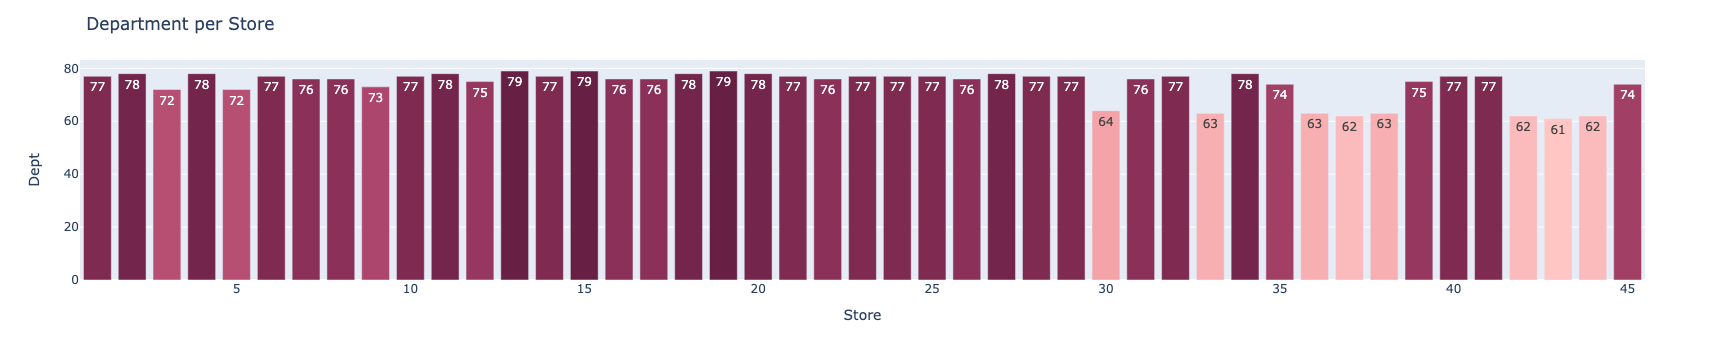

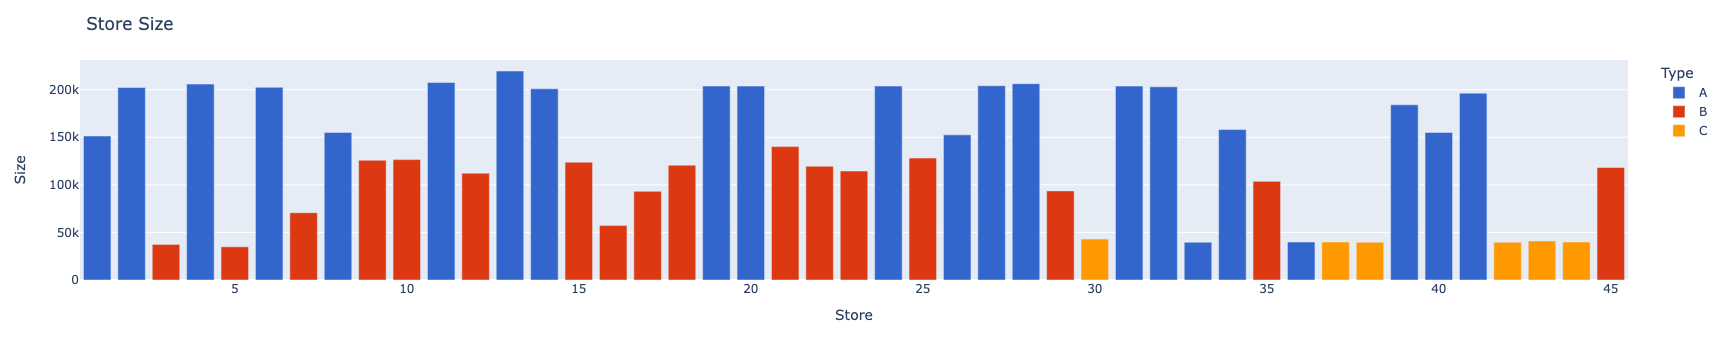

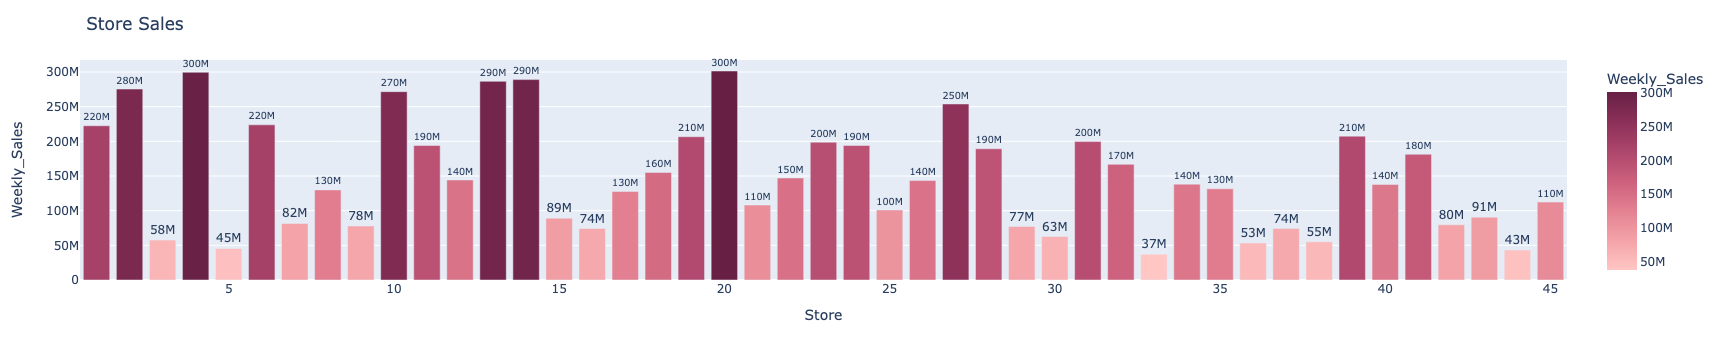

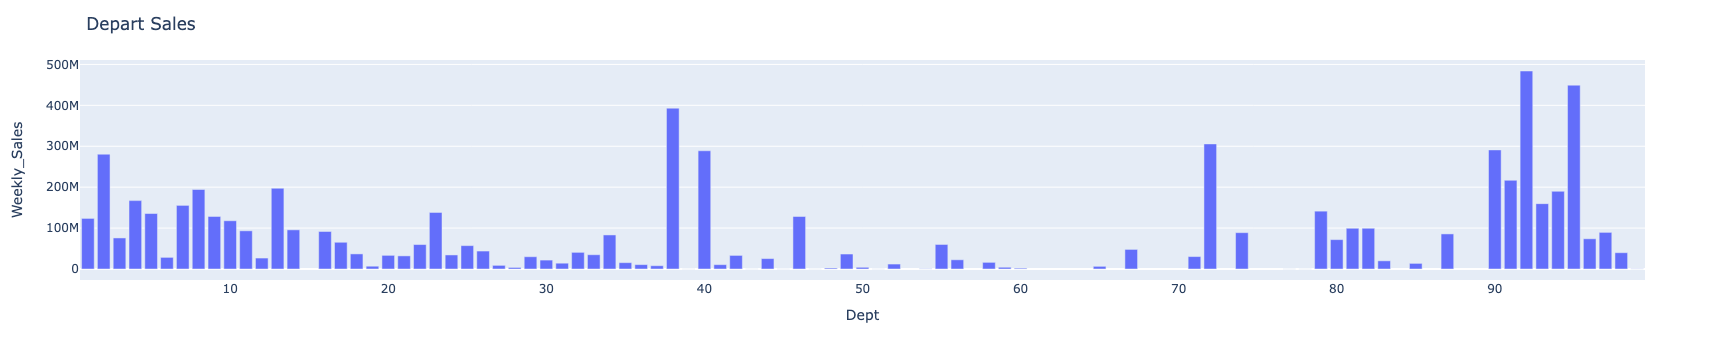

In [99]:
train_df['Store'] = train_df['Store'].astype('category')
temp = train_df.groupby('Store', observed=False)['Dept'].nunique().reset_index()
fig = px.bar(temp, x='Store', y='Dept', color='Dept', color_continuous_scale=px.colors.sequential.Burg, text_auto='.2s')
fig.update_layout(title_text="Department per Store", coloraxis_showscale=False)
fig.show()

temp_2 = store_df.copy()
temp_2['Store'] = temp_2['Store'].astype('category')
fig = px.bar(temp_2, x='Store', y='Size', color='Type', color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(title_text='Store Size')
fig.show()

temp_3 = train_df.groupby('Store', observed=False).Weekly_Sales.sum().reset_index()
fig = px.bar(temp_3, x='Store', y='Weekly_Sales', color='Weekly_Sales', color_continuous_scale=px.colors.sequential.Burg, text_auto='.2s')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(title_text='Store Sales')
fig.show()

temp_4 = train_df.groupby('Dept').Weekly_Sales.sum().reset_index()
fig = px.bar(temp_4, x='Dept', y='Weekly_Sales')
fig.update_layout(title_text='Depart Sales')
fig.show()

Department somewhat correlates with Size and Type. 

In terms of Size, Type A > Type B > Type C.

Store Sales and Size are coorelated.

Some Departments have no sales at all.

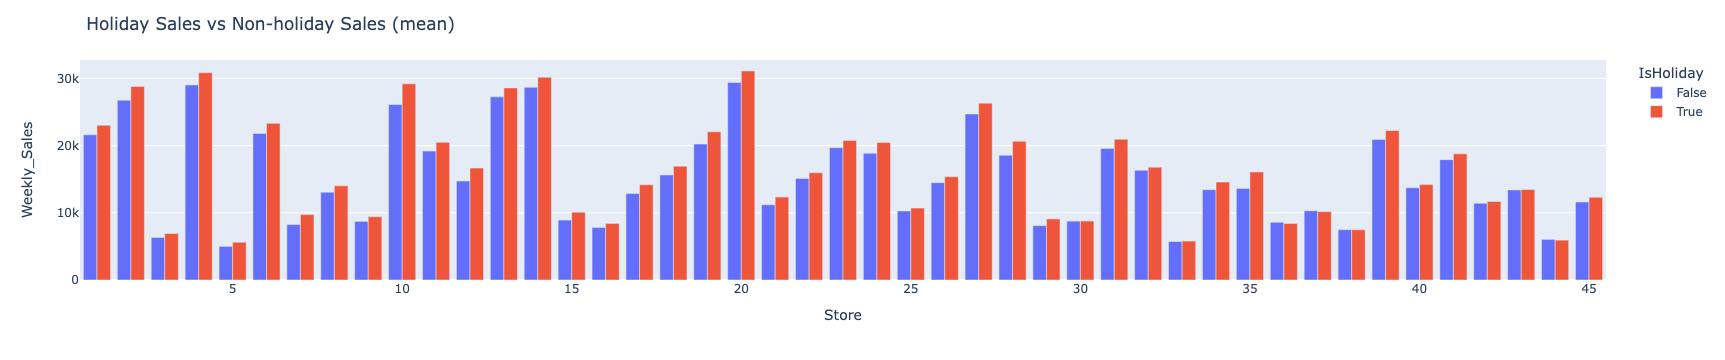

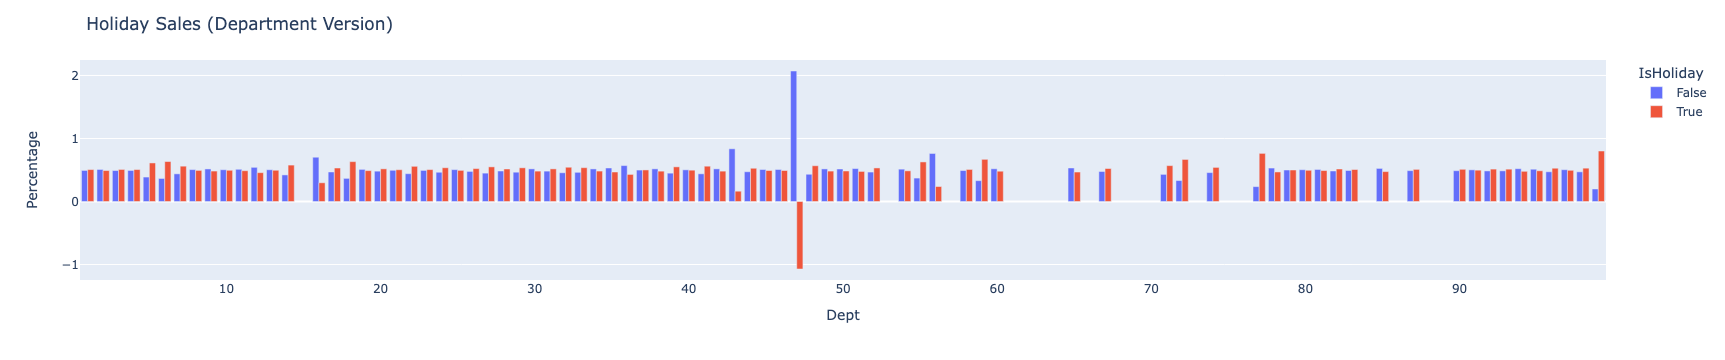

In [137]:
temp = train_df.groupby(['Store', 'IsHoliday'], observed=False).Weekly_Sales.mean().reset_index()
fig = px.bar(temp, x='Store', y='Weekly_Sales', color='IsHoliday', barmode='group')
fig.update_layout(title_text='Holiday Sales vs Non-holiday Sales (mean)')
fig.show()

temp = train_df.groupby(['Dept', 'IsHoliday']).Weekly_Sales.mean().reset_index()
temp_2 = temp.merge(temp.groupby('Dept')['Weekly_Sales'].sum(), on='Dept').rename(columns={'Weekly_Sales_y': 'Sum'})
temp_2['Normalized'] = temp_2['Weekly_Sales_x'] / temp_2['Sum']
fig = px.bar(temp_2, x='Dept', y='Normalized', color='IsHoliday', barmode='group', labels={'Normalized':'Percentage'})
fig.update_layout(title_text='Holiday Sales (Department Version)')
fig.show()

In [151]:
temp = train_df.groupby(['Dept', 'IsHoliday']).Weekly_Sales.mean().reset_index()
temp_2 = temp.merge(temp.groupby('Dept')['Weekly_Sales'].sum(), on='Dept').rename(columns={'Weekly_Sales_y': 'Sum'})
temp_2['Normalized'] = temp_2['Weekly_Sales_x'] / temp_2['Sum']

temp_2[temp_2['Dept'] == 47]

,Dept,IsHoliday,Weekly_Sales_x,Sum,Normalized
90,47,False,-8.822098,-4.259735,2.071044
91,47,True,4.562364,-4.259735,-1.071044


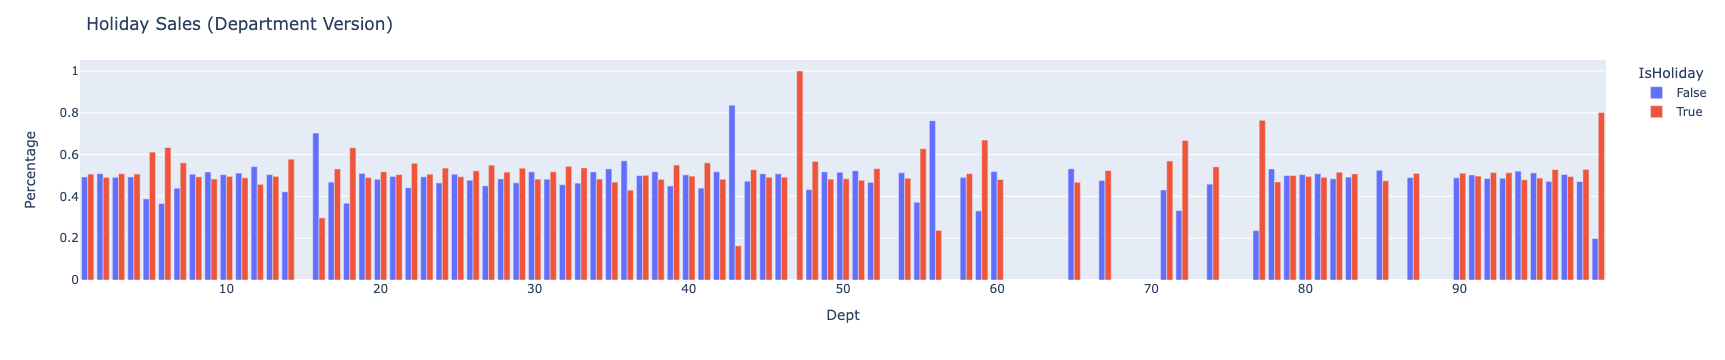

In [153]:
temp = train_df.groupby(['Dept', 'IsHoliday']).Weekly_Sales.mean().clip(0.0).reset_index()
temp_2 = temp.merge(temp.groupby('Dept')['Weekly_Sales'].sum().clip(0.0), on='Dept').rename(columns={'Weekly_Sales_y': 'Sum'})
temp_2['Normalized'] = temp_2['Weekly_Sales_x'] / temp_2['Sum']

fig = px.bar(temp_2, x='Dept', y='Normalized', color='IsHoliday', barmode='group', labels={'Normalized':'Percentage'})
fig.update_layout(title_text='Holiday Sales (Department Version)')
fig.show()

Interesting Dept: 16, 43, 47, 77, 99.

Missing Dept: 15, 53, 57, 61-64, 66, 68, 69, 70, 73, 75, 76, 84, 86, 88, 89.

In [163]:
for i in [15, 53, 57, 61, 62, 63, 64, 66, 68, 69, 70, 73, 75, 76, 84, 86, 88, 89]:
        print(train_df[train_df.Dept == i].index)

Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')
Index([], dtype='int64')


In [164]:
for i in [15, 53, 57, 61, 62, 63, 64, 66, 68, 69, 70, 73, 75, 76, 84, 86, 88, 89]:
    print(test_df[test_df.Dept == i])

Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty DataFrame
Columns: [Store, Dept, Date, IsHoliday]
Index: []
Empty Data

In [182]:
temp = train_df[train_df.Weekly_Sales < 0]
temp.groupby(['Dept'], observed=False).Weekly_Sales.nunique()

Dept
5       1
6      15
9       4
12      1
16      3
18    137
19     63
22      8
23      3
24      4
25      2
26      4
27      2
28      1
31      7
32      5
33      6
34      2
35      1
36      6
37      1
41     12
44     15
45     23
47    128
48     17
49     39
50      2
51     24
52      2
54    106
55      7
56      8
58      1
59     42
60      2
71      9
72     34
74      3
77     16
78     11
80     67
83      1
85      1
93      1
94     57
96     22
97      3
98     22
99      9
Name: Weekly_Sales, dtype: int64

# Feature Creation

In [205]:
# train_df.set_index(['Date'], inplace=True)
train_df['Week'] = train_df.index.isocalendar().week
train_df['Month'] = train_df.index.month
train_df['Quarter'] = train_df.index.quarter
train_df['Year'] = train_df.index.year

In [206]:
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Month,Quarter,Year
Date,,,,,,,,
2010-02-05,1,1,24924.50,False,5,2,1,2010
2010-02-12,1,1,46039.49,True,6,2,1,2010
2010-02-19,1,1,41595.55,False,7,2,1,2010
2010-02-26,1,1,19403.54,False,8,2,1,2010
2010-03-05,1,1,21827.90,False,9,3,1,2010


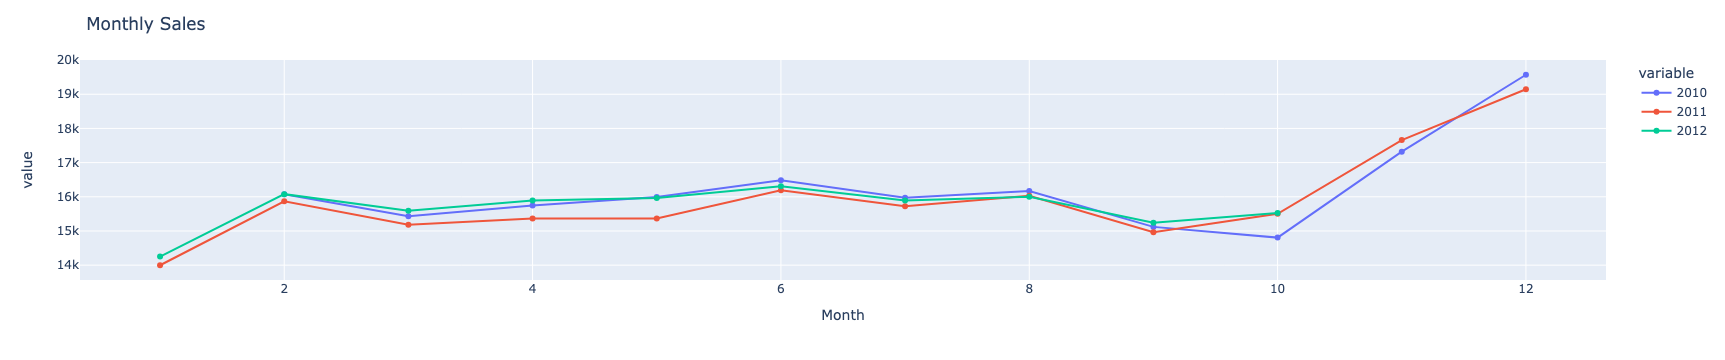

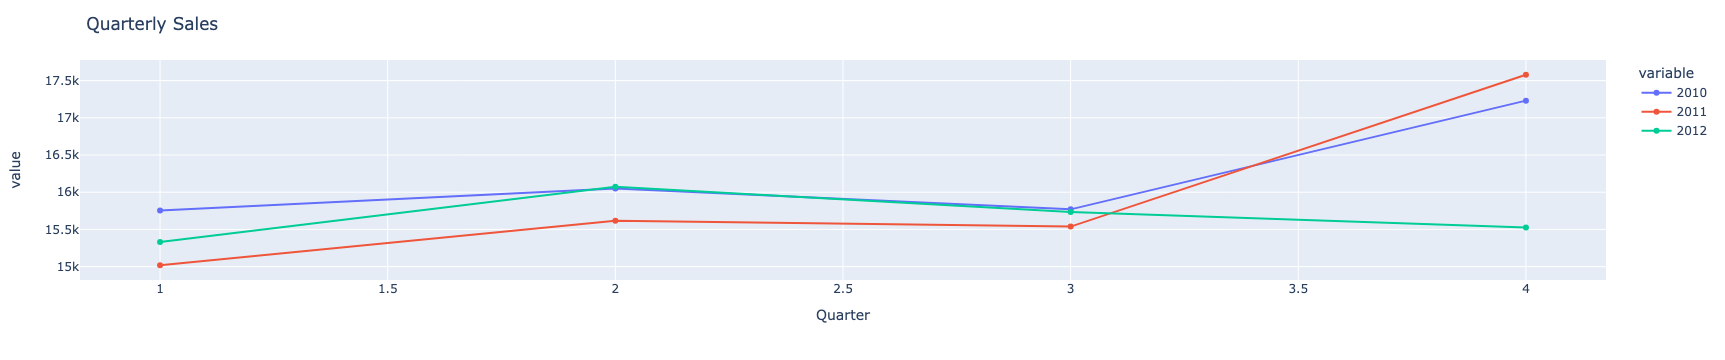

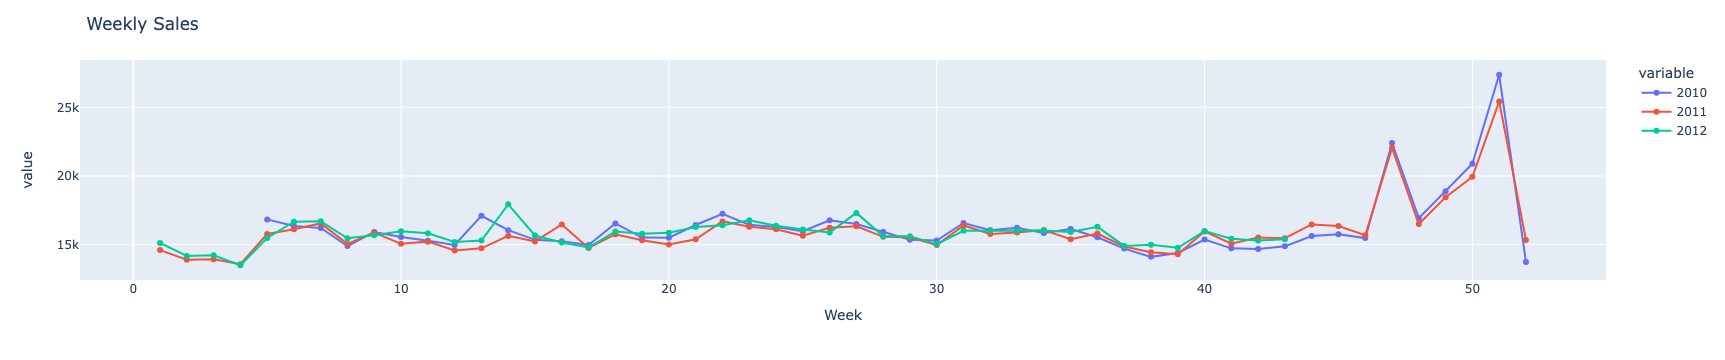

In [234]:
temp = train_df.pivot_table(values='Weekly_Sales', columns='Year', index='Month').reset_index()
fig = px.line(temp, x='Month', y=[2010, 2011, 2012], markers=True, labels={'2010': 'Sales 2010', '2011': 'Sales 2011', '2012': 'Sales 2012'})
fig.update_layout(title_text = 'Monthly Sales')
fig.show()

temp = train_df.pivot_table(values='Weekly_Sales', columns='Year', index='Quarter').reset_index()
fig = px.line(temp, x='Quarter', y=[2010, 2011, 2012], markers=True, labels={'2010': 'Sales 2010', '2011': 'Sales 2011', '2012': 'Sales 2012'})
fig.update_layout(title_text = 'Quarterly Sales')
fig.show()


temp = train_df.pivot_table(values='Weekly_Sales', columns='Year', index='Week').reset_index()
fig = px.line(temp, x='Week', y=[2010, 2011, 2012], markers=True, labels={'2010': 'Sales 2010', '2011': 'Sales 2011', '2012': 'Sales 2012'})
fig.update_layout(title_text = 'Weekly Sales')
fig.show()

A distinct pattern can be seen. Month 11, 12 has increased sales. Especially the week 51 and 47.

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

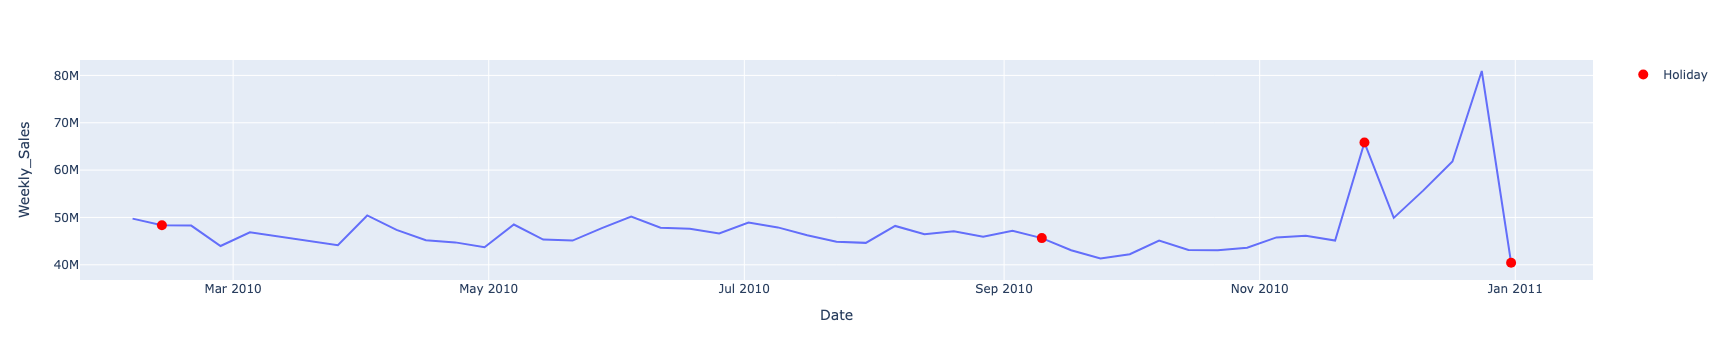

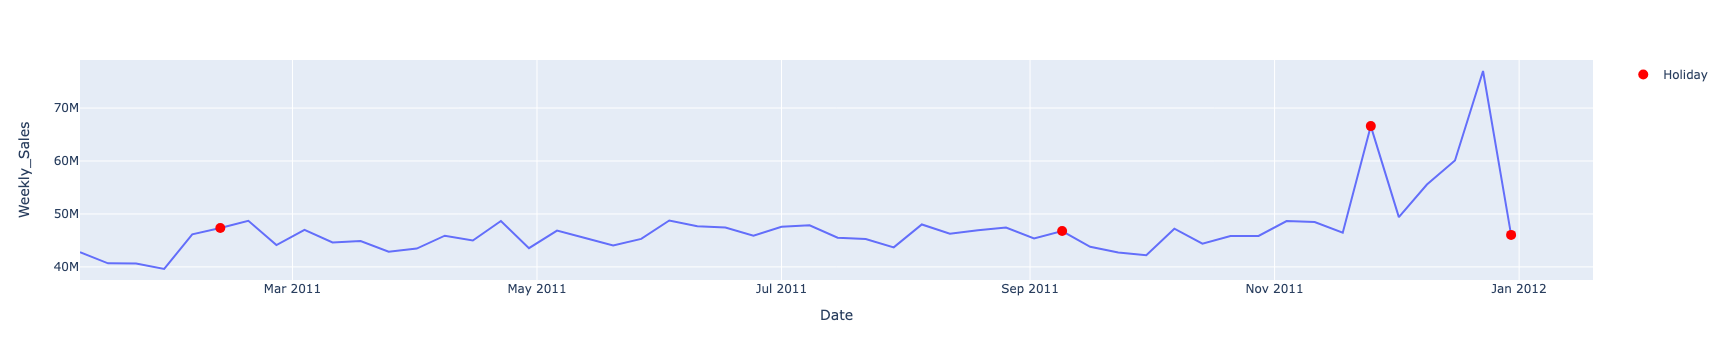

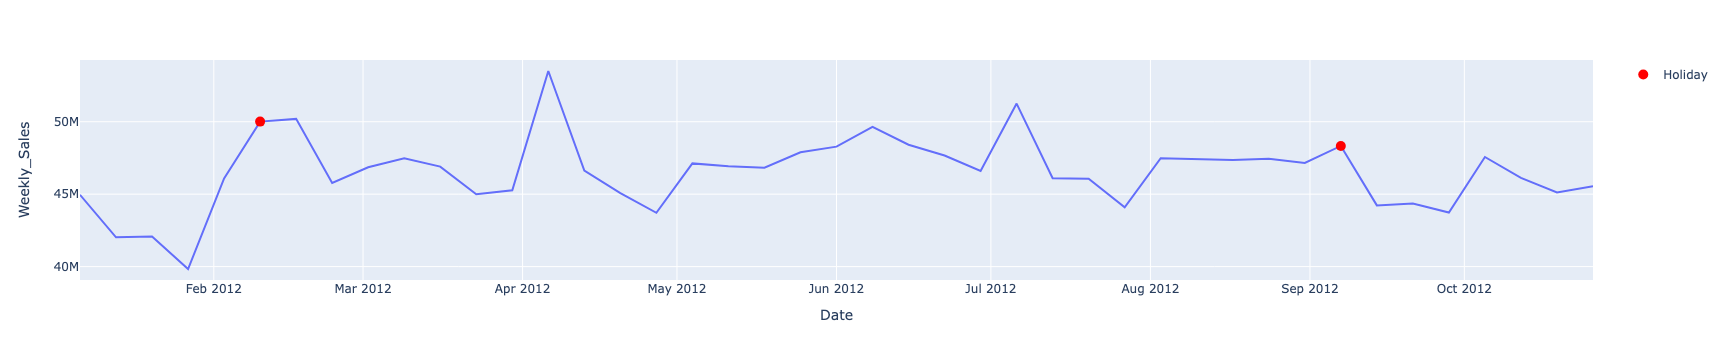

In [294]:
temp = train_df.loc['2010'].groupby(['Date'], observed=False).Weekly_Sales.sum().reset_index()
temp_2 = train_df.loc['2010'].reset_index().drop_duplicates(subset='Date').set_index('Date')
temp_2_holidays = temp_2[temp_2['IsHoliday']].reset_index()
fig = px.line(temp, x=temp.Date, y='Weekly_Sales')
holiday_sales = [temp[temp['Date'] == date]['Weekly_Sales'].values[0] if date in temp['Date'].values else None for date in temp_2_holidays['Date']]
fig.add_scatter(x=temp_2_holidays['Date'], y=holiday_sales, mode='markers', name='Holiday', marker=dict(color='red', size=10))
fig.show()

temp = train_df.loc['2011'].groupby(['Date'], observed=False).Weekly_Sales.sum().reset_index()
temp_2 = train_df.loc['2011'].reset_index().drop_duplicates(subset='Date').set_index('Date')
temp_2_holidays = temp_2[temp_2['IsHoliday']].reset_index()
fig = px.line(temp, x=temp.Date, y='Weekly_Sales')
holiday_sales = [temp[temp['Date'] == date]['Weekly_Sales'].values[0] if date in temp['Date'].values else None for date in temp_2_holidays['Date']]
fig.add_scatter(x=temp_2_holidays['Date'], y=holiday_sales, mode='markers', name='Holiday', marker=dict(color='red', size=10))
fig.show()

temp = train_df.loc['2012'].groupby(['Date'], observed=False).Weekly_Sales.sum().reset_index()
temp_2 = train_df.loc['2012'].reset_index().drop_duplicates(subset='Date').set_index('Date')
temp_2_holidays = temp_2[temp_2['IsHoliday']].reset_index()
fig = px.line(temp, x=temp.Date, y='Weekly_Sales')
holiday_sales = [temp[temp['Date'] == date]['Weekly_Sales'].values[0] if date in temp['Date'].values else None for date in temp_2_holidays['Date']]
fig.add_scatter(x=temp_2_holidays['Date'], y=holiday_sales, mode='markers', name='Holiday', marker=dict(color='red', size=10))
fig.show()

Thanksgiving and Christmas affects the most compared to the other two holidays. We should create a dummy variable for these two holidays. In addition, we should create an addition column for the week before christmas because its the peak sales of the year.

In [208]:
thanksGiving = train_df[train_df['IsHoliday']].reset_index().drop_duplicates('Date').drop(index=[0, 1, 3, 4, 5, 7, 8, 9]).set_index('Date')
christmas = train_df[train_df['IsHoliday']].reset_index().drop_duplicates('Date').drop(index=[0, 1, 2, 4, 5, 6, 8, 9]).set_index('Date')
thanksGiving.index = pd.to_datetime(thanksGiving.index)
christmas.index = pd.to_datetime(christmas.index)

pre_christmas = christmas.index - DateOffset(weeks=1)
pre_christmas

DatetimeIndex(['2010-12-24', '2011-12-23'], dtype='datetime64[ns]', name='Date', freq=None)

# Trend

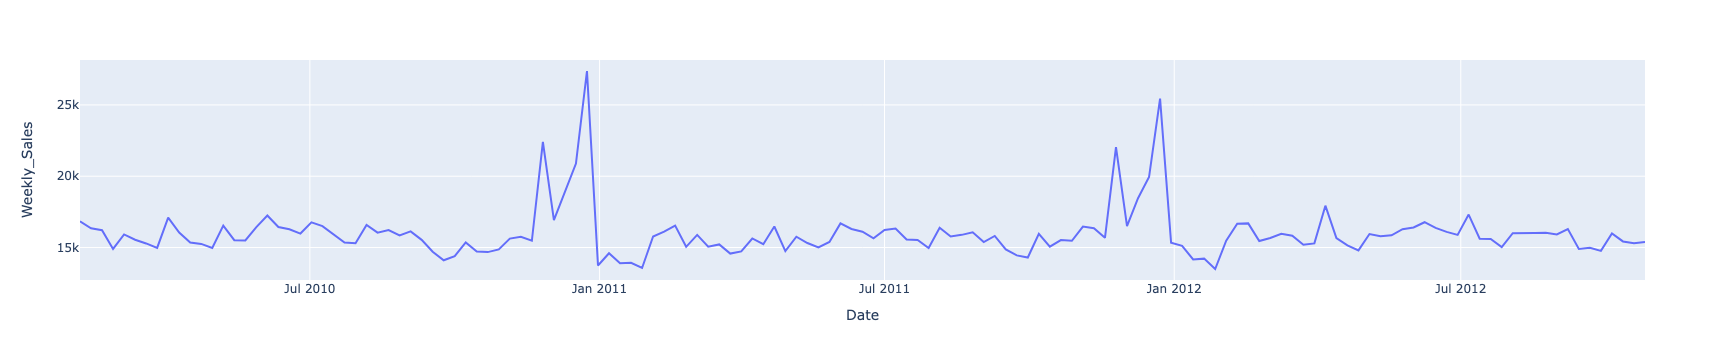

In [336]:
temp = train_df.groupby(['Date'], observed=False).Weekly_Sales.mean().reset_index()
px.line(temp, x='Date', y='Weekly_Sales')

No particular trend is spotted.

# Seasonality & Lags

Peak at Week 47 and 51, Week 48-50 also have higher mean than other months.

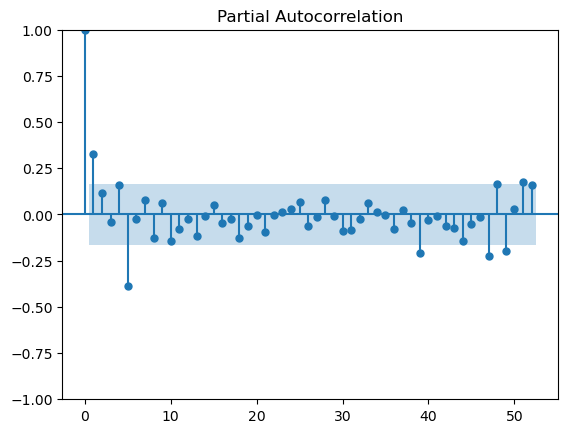

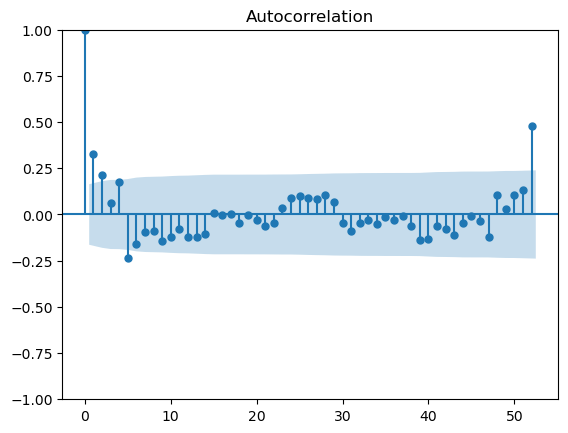

In [349]:
temp = train_df.groupby(['Date'], observed=False).Weekly_Sales.mean().reset_index()
plot_pacf(temp.Weekly_Sales, lags=52)
plt.show()
plot_acf(temp.Weekly_Sales, lags=52)
plt.show()

PCAF : 1 and 5

ACF: 1 and 52

In [203]:
train_frame = train_df.copy()
train_frame['Date'] = pd.to_datetime(train_frame.Date)
train_frame = train_frame.drop(columns=['IsHoliday'], axis=1).set_index(['Store', 'Dept', 'Date']).unstack(['Store', 'Dept'])
test_frame = test_df.copy()
test_frame['Date'] = pd.to_datetime(test_frame.Date)
test_frame['Weekly_Sales'] = 0.0
test_frame = test_frame.drop(columns=['IsHoliday'], axis=1).set_index(['Store', 'Dept', 'Date']).unstack(['Store', 'Dept'])

In [210]:
dp = DeterministicProcess(
    index = train_frame.index,
    constant = True,
    seasonal = True,
    drop = True,
)
X = dp.in_sample()

# Adding holidays
# X['thanksGiving'] = X.index.isin(thanksGiving.index)
# X['christmas'] = X.index.isin(christmas.index)
# X['pre_christmas'] = X.index.isin(pre_christmas)

# try inputing trian_frame = 0.0
imputer = SimpleImputer(fill_value=0.0)
y = imputer.fit_transform(train_frame)
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)
mae(y_true = y, y_pred = y_pred)

1035.7829167321643

In [211]:
y_pred_df = pd.DataFrame(y_pred, index=train_frame.index, columns=train_frame.columns)
y_df = pd.DataFrame(y, index=train_frame.index, columns=train_frame.columns)

In [212]:
def plot_weekly_sales(y_df, y_pred_df, store:int, dept:int):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=y_pred_df, x=y_pred_df.index, y=y_pred_df['Weekly_Sales', store, dept], label='predicted', alpha=0.5)
    sns.lineplot(data=y_df, x=y_df.index, y=y_df['Weekly_Sales', store, dept], label='actual', alpha=0.5)
    plt.show()

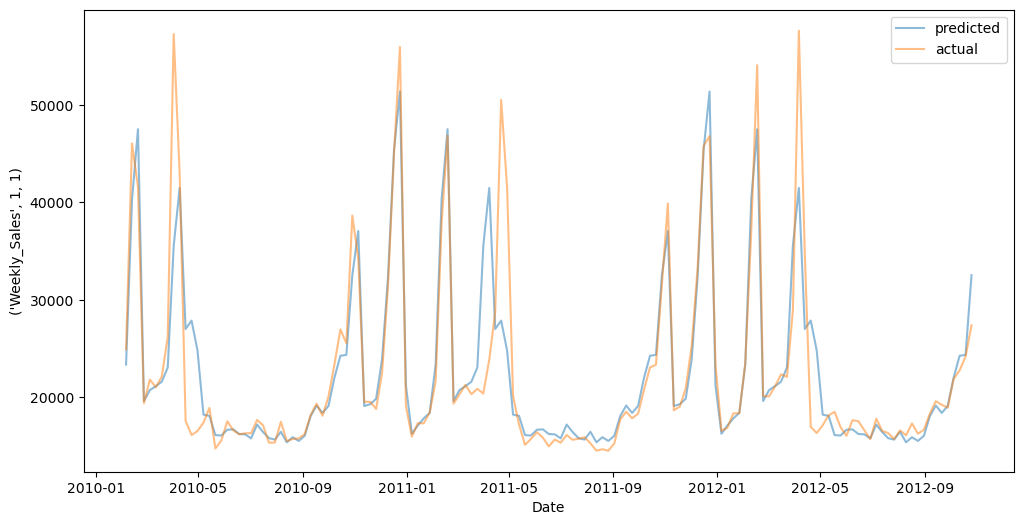

In [213]:
plot_weekly_sales(y_df, y_pred_df, 1, 1)

In [214]:
len(test_frame.index)

39

In [215]:
X_test = dp.out_of_sample(39, forecast_index=test_frame.index)

In [216]:
y_pred_test_all_combination = pd.DataFrame(linear_model.predict(X_test), index=test_frame.index, columns=train_frame.columns)

In [228]:
y_pred_test = y_pred_test_all_combination.stack(['Store', 'Dept'], future_stack=True).reset_index()

In [233]:
y_pred_test

,Date,Store,Dept,Weekly_Sales
0,2012-11-02,1,1,37062.470000
1,2012-11-02,1,2,46847.525000
2,2012-11-02,1,3,9507.210000
3,2012-11-02,1,4,38667.695000
4,2012-11-02,1,5,27929.940000
...,...,...,...,...
129904,2013-07-26,45,94,4122.054030
129905,2013-07-26,45,95,53433.756667
129906,2013-07-26,45,96,2.970000
129907,2013-07-26,45,97,6217.076667


In [243]:
test_df.Date = pd.to_datetime(test_df.Date)
submission_df = test_df.merge(y_pred_test, on=['Date', 'Store', 'Dept'])
submission_df['Id'] = (
    submission_df['Store'].astype(str) + '_' + submission_df['Dept'].astype(str) + '_' + submission_df['Date'].astype(str)
)

In [244]:
submission_df.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales,Id
0,1,1,2012-11-02,False,37062.470,1_1_2012-11-02
1,1,1,2012-11-09,False,19119.465,1_1_2012-11-09
2,1,1,2012-11-16,False,19301.750,1_1_2012-11-16
3,1,1,2012-11-23,True,19865.770,1_1_2012-11-23
4,1,1,2012-11-30,False,23905.525,1_1_2012-11-30


In [245]:
sample_df.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [253]:
first_submission = sample_df[['Id']].merge(submission_df[['Weekly_Sales', 'Id']], how='left').fillna(0.0)
first_submission.to_csv('first_submssion.csv', index=False)